In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Mexican Gothic, Moreno-Garcia",118.744531,4.240876,12.698491,28
Azure Functions Core Tools,167.176234,9.833896,21.908117,17
OAuth 2.0 RFC6749,102.386873,25.596718,26.935752,4
Node.js and Vite,1139.927995,27.803122,48.879435,41
Django,1145.140845,28.628521,44.553286,40
Azure Files Documentation,2416.632636,40.277211,134.305558,60
FSLogix,134.030429,44.676810,51.301595,3
Active Directory and Azure Files,1800.508520,48.662392,93.334608,37
CCH Tax Forms Project,1028.978148,48.998959,116.573789,21
Python + Oauth2.0,1356.130971,58.962216,132.929422,23


# Histogram

sum of ages: ~53171.63


<Axes: >

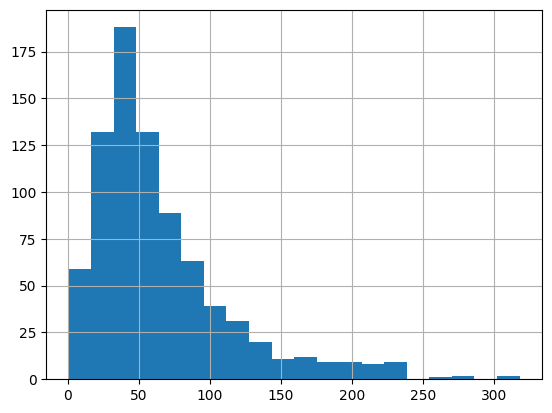

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53171.63


<Axes: >

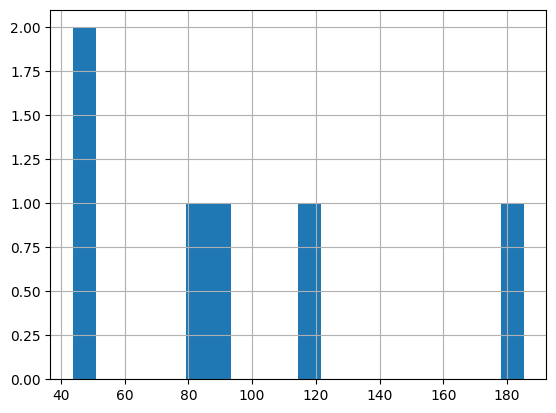

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='VMWare']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 816
Total card age: 53171.63


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
100,FSLogix,Outlook OST Files:\nOffline Storage Table file...,b0fab81453cc4b8f050b83f205971368,51.301595,44.676810,-51.301595,134.030429,0.373489,3,0,0,-51.301595
101,FSLogix,"On a lazy asynchronous operation, Cloud Cache ...",7479d6959474935e10265a7ef6ccf617,47.927539,44.676810,-51.301595,134.030429,0.373489,3,1,0,-47.927539
102,FSLogix,Q: Which format does FSLogix use to store user...,2502a81cff9047e83fa1e04a99225de5,34.801294,44.676810,-51.301595,134.030429,0.373489,3,2,0,-34.801294
114,OAuth 2.0 RFC6749,"In OAuth, the client requests access to resour...",b9723a2c9da1d1e42eed8523f10cd1f1,26.935752,25.596718,-26.935752,102.386873,0.356485,4,0,0,-26.935752
113,OAuth 2.0 RFC6749,"For example, an end-user (resource owner) can ...",0d117fe985e282b6d6989e4d7ba0a370,26.451105,25.596718,-26.935752,102.386873,0.356485,4,1,0,-26.451105
115,OAuth 2.0 RFC6749,OAuth defines four roles:\n\n resource owner...,cf40615cb8db6d57638ce918affc0082,25.035937,25.596718,-26.935752,102.386873,0.356485,4,2,0,-25.035937
116,OAuth 2.0 RFC6749,Access tokens\n are issued to third-party cl...,aa6002231b9f45492bb6097a7b6045cf,23.964080,25.596718,-26.935752,102.386873,0.356485,4,3,0,-23.964080
55,VMWare,DirectPath I/O\n\nA feature in VMware ESXi tha...,287a455db958ae907155d77816efe340,185.276505,94.475084,-185.276505,566.850502,0.711223,6,0,0,-185.276505
56,VMWare,VMFS (Virtual Machine File System)\n\nA high-p...,4714701a98c9792497b7296b56747546,115.394538,94.475084,-185.276505,566.850502,0.711223,6,1,0,-115.394538
57,VMWare,VMware Horizon\n\nA VMware product used for Vi...,e3daf2b77d53053ed431bba3138c4d44,93.150485,94.475084,-185.276505,566.850502,0.711223,6,2,0,-93.150485



## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(630.2388296503118)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,318.153214,83.592158,-318.153214,4096.015759,0.237786,49,0,0,-318.153214
5,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,307.135379,94.044874,-307.135379,3385.615474,0.682636,36,0,0,-307.135379
10,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,277.843580,72.897981,-277.843580,5175.756645,0.431712,71,0,0,-277.843580
15,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,271.244428,77.996763,-271.244428,2573.893183,0.660315,33,0,0,-271.244428
20,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,266.270438,98.753594,-266.270438,1975.071889,0.048334,20,0,0,-266.270438
30,CCH Axcess,Client IDs can have up to 15 characters and ca...,220856831fa9fb7a8c1022a5ce48fb6d,238.015706,82.018643,-238.015706,4839.099925,0.256218,59,0,0,-238.015706
1,Terraform Codebox,Terraform Registry is where official and commu...,5aeeebf71219ff35da683979c85ed7aa,237.434234,83.592158,-318.153214,4096.015759,0.237786,49,1,0,-237.434234
25,JavaScript Concepts,Reserved Words: Identifiers cannot be the same...,042a95e59a28c2e0d94382aacc1a1751,237.414358,75.962562,-237.414358,3874.090676,0.243200,51,0,0,-237.414358
6,PnP PowerShell,SecureString (System.Security)\nRepresents tex...,3f7ff24c8e8b4e8581647dd62bc05060,236.614575,94.044874,-307.135379,3385.615474,0.682636,36,1,0,-236.614575
35,Azure VM + Developer,Port Forwarding\nAn SSH feature that lets you ...,ab24eca09d42d7293e8d28293893ab14,232.170286,97.029006,-232.170286,2231.667142,0.666684,23,0,0,-232.170286


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 65.161'